In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

In [3]:
import cv2
import numpy as np;
from random import randrange
from math import pi, fabs

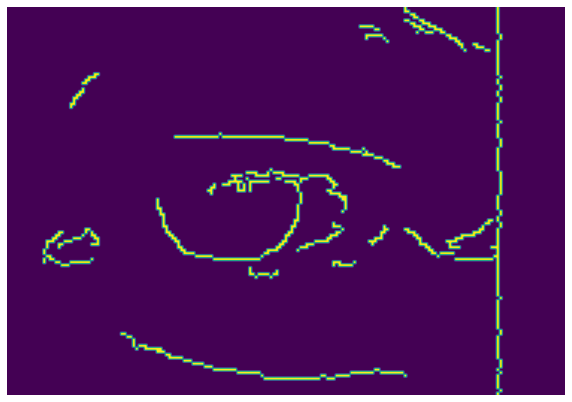

In [11]:
# Preparing input image
im_rgb = cv2.imread("./data/imgs/y2.png", cv2.IMREAD_COLOR)
im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)

# Doing Canny edge detector
edges = cv2.Canny(im_gray, 100, 180)

# Displaying Canny edge detector results
plt.imshow(edges)
plt.axis('off')
plt.show()

In [6]:
contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Check each contour
for contour in contours:
    # Ellipse can be fitted only by 5 points, not less
    if len(contour)>=5:
        # Fitting an ellipse by input points set by built-in OpenCV function (will do it be Least Squares fit)
        el = cv2.fitEllipse(contour)    
        # Picking some non-red random color to draw all fitted ellipses
        color = (randrange(128,255), randrange(128,255), 0)
        
        #or pick red color for circle
        (x, y), (MA, ma), angle = el
        area = 0.25 * MA * ma * np.pi
        perimeter = np.pi * np.sqrt((MA ** 2 + ma ** 2) / 2)
        circularity = 4*pi*area/(perimeter*perimeter)
        if circularity > 0.9:
            color = (225,0,0)
        cv2.ellipse(im_rgb, el, color, 2)                

# Displaying resulting image       
plt.imshow(im_rgb)
plt.show()

NameError: name 'edges' is not defined

In [7]:
import cv2
import numpy as np;
from random import randrange
from math import pi, fabs

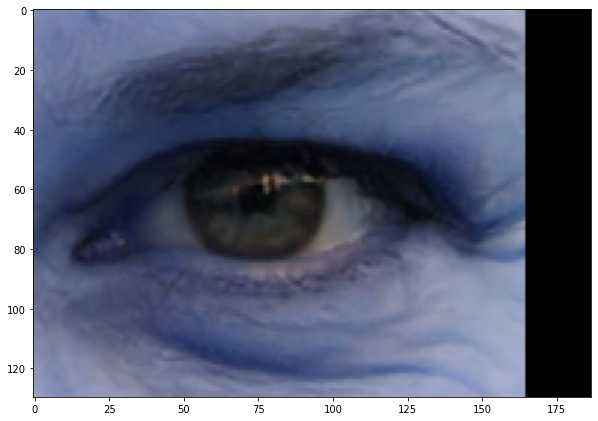

In [10]:
# Preparing input image
im_rgb = cv2.imread("./data/imgs/y2.png", cv2.IMREAD_COLOR)
plt.imshow(im_rgb)

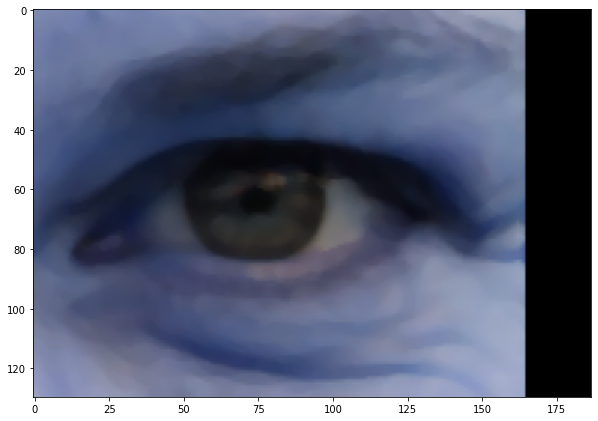

In [132]:
blurred = cv2.medianBlur(im_rgb, 5)
plt.imshow(blurred)
plt.show()

In [133]:
ksize = 31
sigma = pi
theta = 30
lambd = 9
gamma = 0.8
my_kernel1 = cv2.getGaborKernel((ksize,ksize), sigma, theta, lambd , gamma, psi = 0)
my_kernel2 = cv2.getGaborKernel((ksize,ksize), sigma, 0, lambd , gamma, psi = 0)

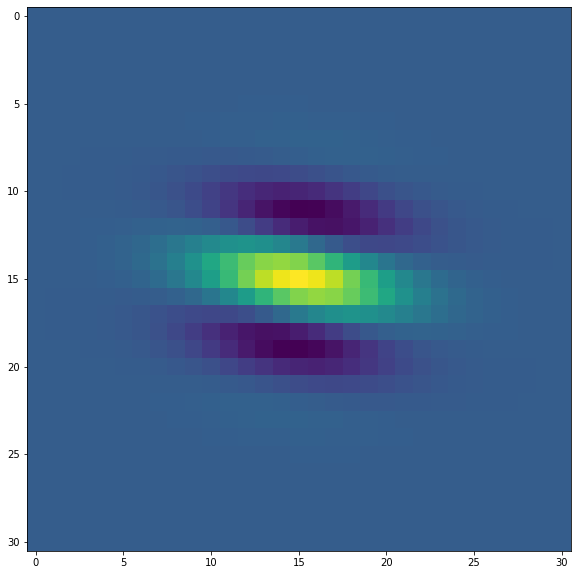

In [134]:
plt.imshow(my_kernel1)

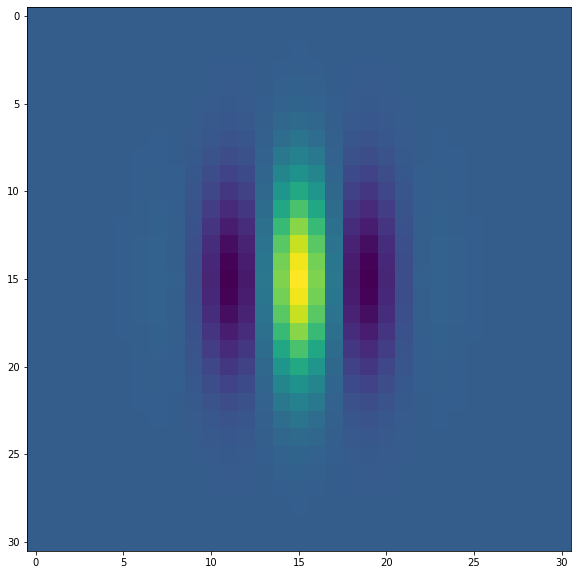

In [135]:
plt.imshow(my_kernel2)

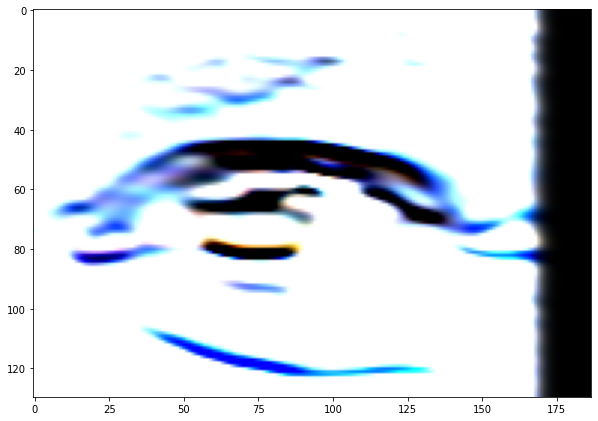

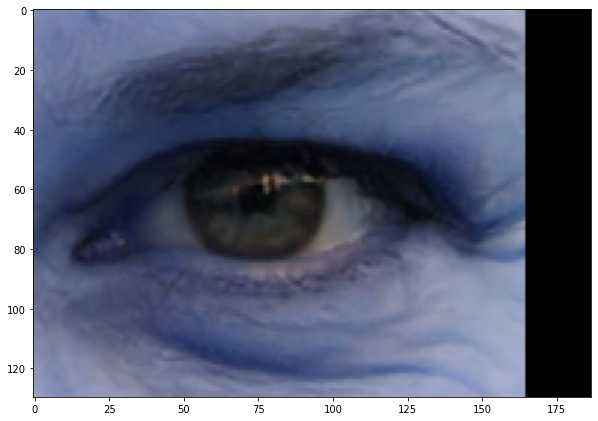

In [136]:
res1 = cv2.filter2D(im_rgb, ddepth = -1, kernel = my_kernel1)
plt.imshow(res1)
plt.show()
plt.imshow(im_rgb)

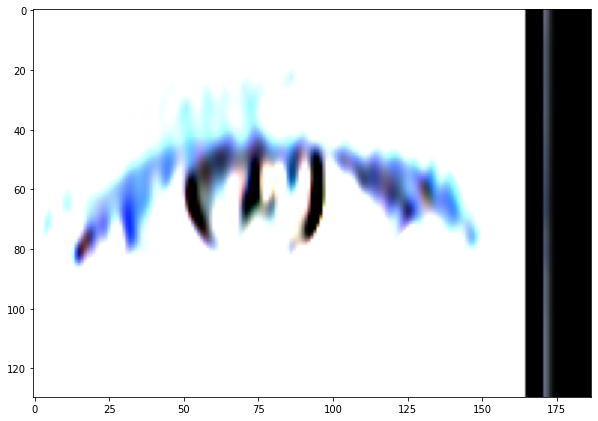

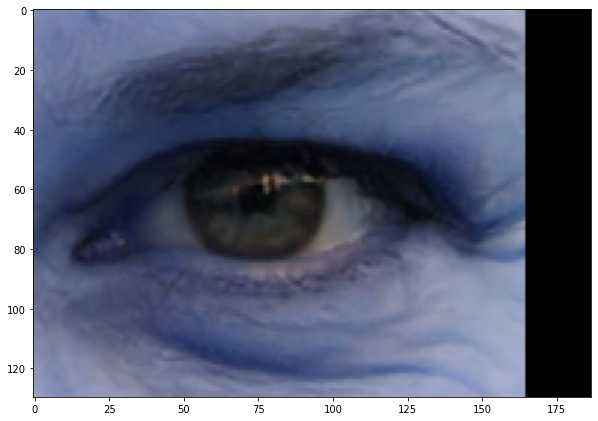

In [137]:
res2 = cv2.filter2D(im_rgb, ddepth = -1, kernel = my_kernel2)
plt.imshow(res2)
plt.show()
plt.imshow(im_rgb)

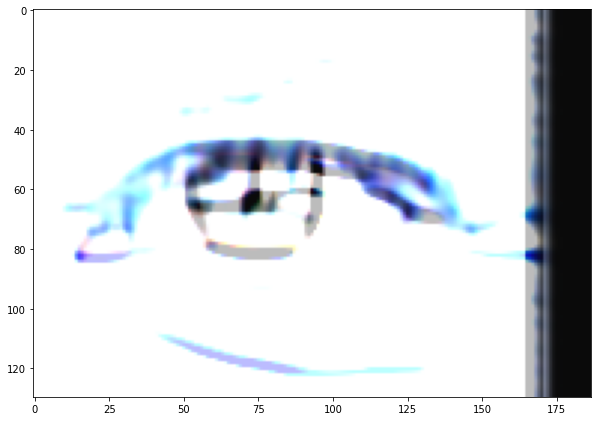

In [157]:
res3 = cv2.addWeighted(res1, 0.7, res2, 0.7, 10)
plt.imshow(res3)
plt.show()

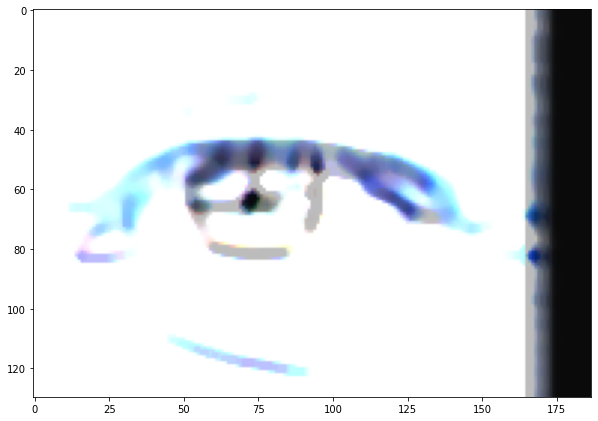

In [158]:
blurred2 = cv2.medianBlur(res3, 5)
plt.imshow(blurred2)
plt.show()

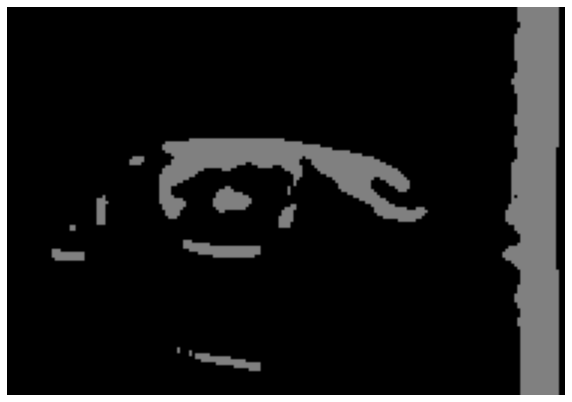

In [159]:

# Converting input image to grayscale
res_gray = cv2.cvtColor(blurred2, cv2.COLOR_BGR2GRAY)

# Doing adaptiveTreshold on grayscale input image to detect regions with big enough local change of a color
res_im = cv2.adaptiveThreshold(res_gray, 128, cv2.ADAPTIVE_THRESH_MEAN_C,  cv2.THRESH_BINARY_INV, 41, 30)

# Drawing adaptiveTreshold results with gray color
res_im_verbose = cv2.cvtColor(res_im, cv2.COLOR_GRAY2BGR)
plt.imshow(res_im_verbose)
plt.axis('off')
plt.show()

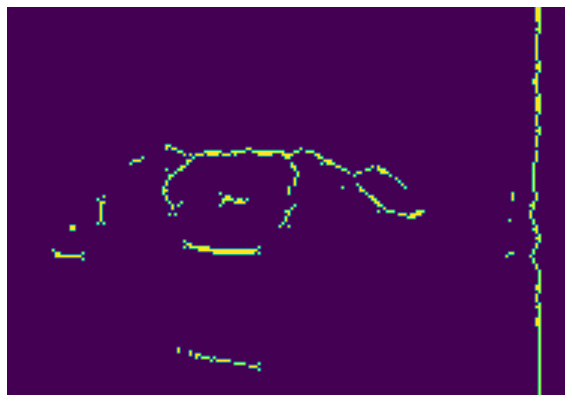

In [160]:
size = np.size(res_im_verbose)
skel = np.zeros(res_im.shape,np.uint8)
ret,res_im = cv2.threshold(res_im,127,255,0)
 

# Doing morphological skeletonisation with barebone OpenCV
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
done = False
while(not done):
    eroded = cv2.erode(res_im,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(res_im,temp)
    skel = cv2.bitwise_or(skel,temp)
    res_im = eroded.copy()
    zeros = size - cv2.countNonZero(res_im)
    if zeros==size:
        done = True

# Displaying skeletonisation results
plt.imshow(skel)
plt.axis('off')
plt.show()

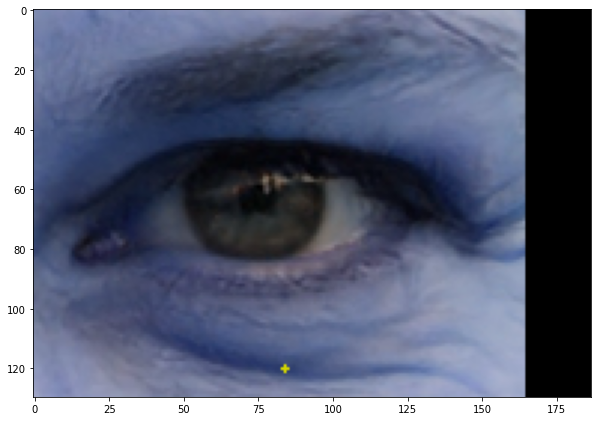

In [161]:
contours, hierarchy = cv2.findContours(skel, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Check each contour
for contour in contours:
    # Ellipse can be fitted only by 5 points, not less
    if len(contour)>=5:
        # Fitting an ellipse by input points set by built-in OpenCV function (will do it be Least Squares fit)
        el = cv2.fitEllipse(contour)    
        # Picking some non-red random color to draw all fitted ellipses
        color = (randrange(128,255), randrange(128,255), 0)
        
        #or pick red color for circle
        (x, y), (MA, ma), angle = el
        area = 0.25 * MA * ma * np.pi
        perimeter = np.pi * np.sqrt((MA ** 2 + ma ** 2) / 2)
        circularity = 4*pi*area/(perimeter*perimeter)
        if circularity > 0.9:
            cv2.ellipse(im_rgb, el, color, 2) 
        #cv2.ellipse(im_rgb, el, color, 2)                

# Displaying resulting image       
plt.imshow(im_rgb)
plt.show()

## adaptiveThreshold -> Skeletonize -> Ransac
Simple RANSAC circle class refactored from https://github.com/SeongHyunBae/RANSAC-circle-python 

In [262]:
import cv2
import numpy as np;
from random import randrange
from math import pi, fabs, sin, cos
from numpy.linalg import inv

In [196]:
# Target ball radius (known apriori)
radius = 10.0

class SIMPLE_CIRCLE_RANSAC:    
    def __init__(self, x_data, y_data, n):
        self.x_data = x_data
        self.y_data = y_data
        self.n = n
        self.best_inliers = 0
        self.best_model = None

    def random_sampling(self):
        sample = []
        save_ran = []
        count = 0

        # get three points from data
        while True:
            ran = np.random.randint(len(self.x_data))

            if ran not in save_ran:
                sample.append((self.x_data[ran], self.y_data[ran]))
                save_ran.append(ran)
                count += 1

                if count == 3:
                    break

        return sample

    def make_model(self, sample):
        # calculate a circlre from three points

        pt1 = sample[0]
        pt2 = sample[1]
        pt3 = sample[2]

        A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]])
        B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])

        inv_A = inv(A)

        c_x, c_y = np.dot(inv_A, B) / 2
        c_x, c_y = c_x[0], c_y[0]
        r = np.sqrt((c_x - pt1[0])**2 + (c_y - pt1[1])**2)

        return c_x, c_y, r

    def eval_model(self, model):
        # Check is this circle is good enough as a ball candidate
        inliers = 0
        c_x, c_y, r = model

        if (r > radius/2-5) and (r < radius/2+5): # checking target radius
            for i in range(len(self.x_data)):
                dis = np.sqrt((self.x_data[i]-c_x)**2 + (self.y_data[i]-c_y)**2)
                if fabs(dis-r) < 3.0:  # hardcoded inliers distance tolerance
                    inliers += 1

        return inliers

    def execute_ransac(self):
        # Performing RANSAC algorythm
        for i in range(self.n):
            try:
                model = self.make_model(self.random_sampling())
            except np.linalg.LinAlgError as err:
                continue

            inliers = self.eval_model(model)

            if inliers > self.best_inliers:
                self.best_model = model
                self.best_inliers = inliers

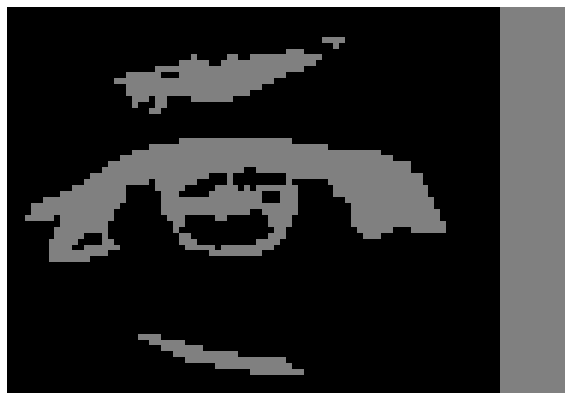

In [263]:
# Loading input image
im_rgb = cv2.imread("../data/imgs/y2.png", cv2.IMREAD_COLOR)

# Downsizeing the input imgae to speed up computations (python implimentation of RANSAC is reeealy slow)
im_rgb = cv2.pyrDown(im_rgb)

# Converting input image to grayscale
im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)

# Doing adaptiveTreshold on grayscale input image to detect regions with big enough local change of a color
im = cv2.adaptiveThreshold(im_gray, 128, cv2.ADAPTIVE_THRESH_MEAN_C,  cv2.THRESH_BINARY_INV, 41, 30)

# Drawing adaptiveTreshold results with gray color
im_verbose = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
plt.imshow(im_verbose)
plt.axis('off')
plt.show()

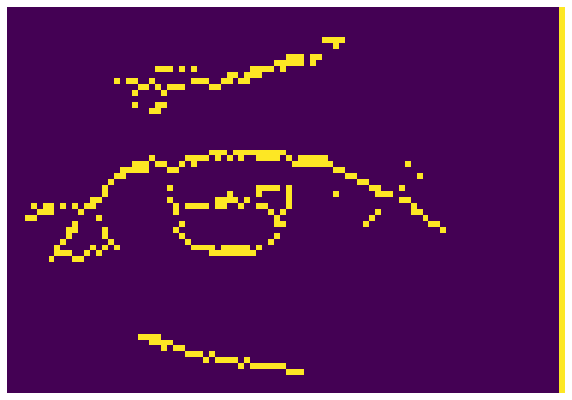

In [264]:
size = np.size(im)
skel = np.zeros(im.shape,np.uint8)
ret,im = cv2.threshold(im,127,255,0)
 
# Set this to 1 to use Zhang-Suen skeletonisation
# This will give better results, but requires opencv-contrib-python package installed by "pip install opencv-contrib-python"
# Set this to 0 if you don't want to install additional packages, 
# processing will be based on barebone OpenCV (slower and worser results but works)

USE_OPENCV_CONTRIB = 0

# Doing skeletonisation
if USE_OPENCV_CONTRIB:
    # Doing Zhang-Suen skeletonisation (gives better results, but requires opencv-contrib-python package installed)
    skel = cv2.ximgproc.thinning(im)
else:
    # Doing morphological skeletonisation with barebone OpenCV
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False
    while( not done):
        eroded = cv2.erode(im,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(im,temp)
        skel = cv2.bitwise_or(skel,temp)
        im = eroded.copy()

        zeros = size - cv2.countNonZero(im)
        if zeros==size:
            done = True

# Displaying skeletonisation results
plt.imshow(skel)
plt.axis('off')
plt.show()

### Marking pixels of skeletonisation on adaptiveThresold image with green color


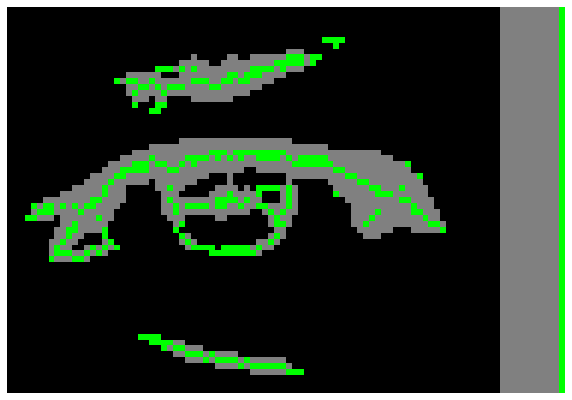

In [218]:
indices = np.where(skel==255)
im_verbose[indices[0], indices[1], :] = [0, 255, 0]
# Displaying skeletonisation on adaptiveThresold image
plt.imshow(im_verbose)
plt.axis('off')
plt.show()

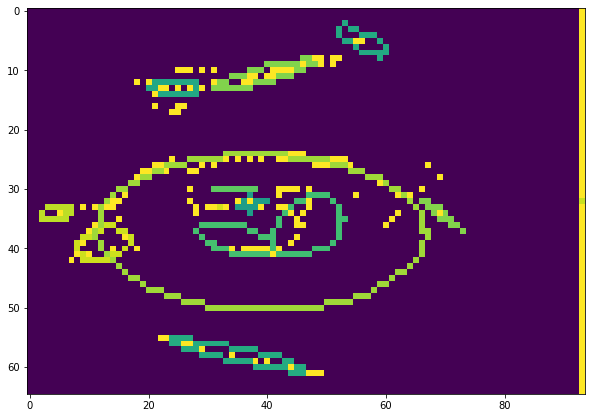

In [265]:
contours, _ = cv2.findContours(skel, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# Check each contour
for contour in contours:
    # Ellipse can be fitted only by 5 points, not less
    if len(contour)>=5:
        # Fitting an ellipse by input points set by built-in OpenCV function (will do it be Least Squares fit)
        el = cv2.fitEllipse(contour)    
        # Picking some non-red random color to draw all fitted ellipses
        color = (randrange(128,255), randrange(128,255), 0)
        w = el[1][0];
        h = el[1][1]
        # If ellipse size (by it's bounding rect) is close to ball size - draw it by thick red circle
        if w > radius-10 and h > radius-10 and w < radius+10 and h < radius+10:
            color = (0,0,255)
        cv2.ellipse(skel, el, color, 1)                

# Displaying resulting image       
plt.imshow(skel)
plt.show()

### Performing RANSAC on skeletonised image

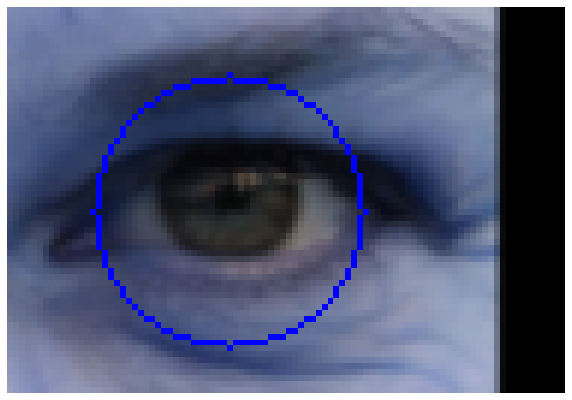

In [266]:
ransac = SIMPLE_CIRCLE_RANSAC( x_data=indices[1], y_data=indices[0], n=50000 )
ransac.execute_ransac()
# Picking RANSAC best fit
a, b, r = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2]
# Drawing RANSAC best fit
cv2.circle(im_rgb, (int(a),int(b)), int(r), (0,0,255),1)

# Displaying resulting image
plt.imshow(im_rgb)
plt.axis('off')
plt.show()

## large kernel adaptiveTreshold -> findContours -> fitEllipse
Known ball radius used for false positives check

In [45]:
import cv2
import numpy as np
from random import randrange
from math import pi, fabs, sin, cos
from numpy.linalg import inv

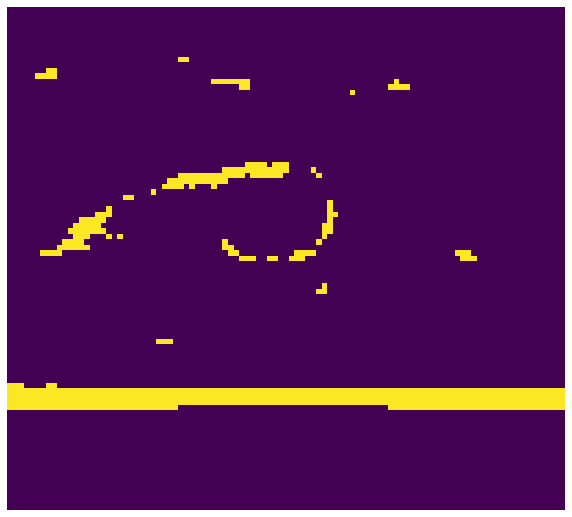

In [272]:
#target ball radius
radius = 50

# Loading input image
im_rgb = cv2.imread("../data/imgs/y1.png", cv2.IMREAD_COLOR)

# Downsizeing the input image to speed up computations
im_rgb = cv2.pyrDown(im_rgb)

# Converting input image to grayscale
im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)

# Doing large kernel adaptive treshold - this will detect the whole ball because it's brighter that it's neighborhood
im = cv2.adaptiveThreshold(im_gray, 64, cv2.ADAPTIVE_THRESH_MEAN_C,  cv2.THRESH_BINARY_INV, 15, 25)
plt.imshow(im)
# Displaying adaptiveTreshold results (compare it with previous notebook adaptiveTreshold usage!)
#plt.imshow(im)
plt.axis('off')
plt.show()

### Preparing an RGB image to draw tedected contours

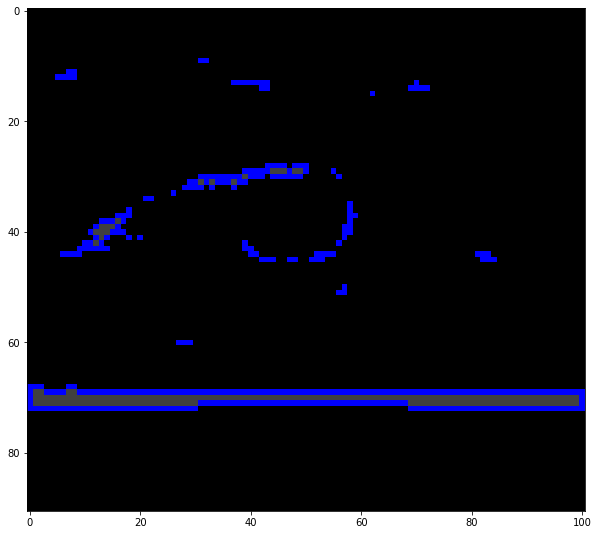

In [273]:

im_contours = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
im_verbose = im_rgb.copy()

# Doing findCountours as before
contours, _ = cv2.findContours(im, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Displaying findContours results
cv2.drawContours(im_contours, contours, -1, (0,0,255), 1)
plt.imshow(im_contours)
plt.show()

### Fitting ellipses for contours and checking their sizes. Correct ellipses will be drawn by red color


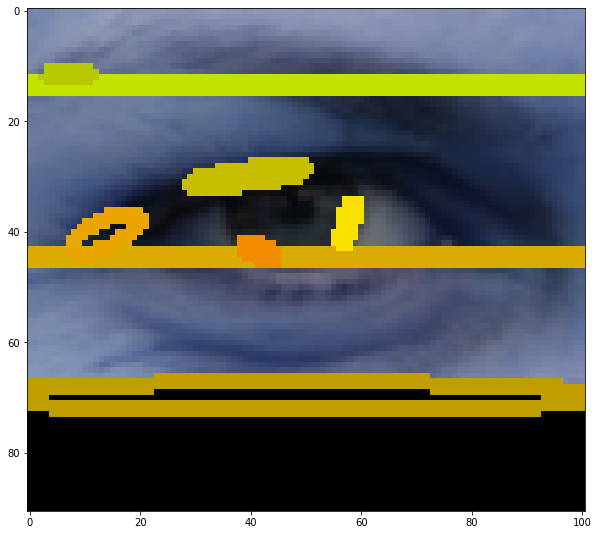

In [274]:
# Check each contour
for contour in contours:
    # Ellipse can be fitted only by 5 points, not less
    if len(contour)>=5:
        # Fitting an ellipse by input points set by built-in OpenCV function (will do it be Least Squares fit)
        el = cv2.fitEllipse(contour)    
        # Picking some non-red random color to draw all fitted ellipses
        color = (randrange(128,255), randrange(128,255), 0)
        w = el[1][0];
        h = el[1][1]
        # If ellipse size (by it's bounding rect) is close to ball size - draw it by thick red circle
        if w > radius-10 and h > radius-10 and w < radius+10 and h < radius+10:
            color = (0,0,255)
        cv2.ellipse(im_verbose, el, color, 2)                

# Displaying resulting image       
plt.imshow(im_verbose)
plt.show()